In [1]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import warnings
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5
common_path = '/kaggle/input/child-mind-institute-problematic-internet-use'

def process_file(filename, dirname):
    try:
        df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
        df.drop('step', axis=1, inplace=True)
        return df.describe().values.reshape(-1), filename.split('=')[1]
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None, None

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*[res for res in results if res[0] is not None])
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

def update_categorical_columns(df, cat_columns):
    for col in cat_columns:
        df[col] = df[col].fillna('Missing').astype('category')
    return df

def create_mapping(column, train, test):
    combined_data = pd.concat([train[column], test[column]], axis=0)
    unique_values = combined_data.unique()
    return {value: idx for idx, value in enumerate(unique_values)}

def apply_mapping(df, mapping, column):
    df[column] = df[column].replace(mapping).astype(int)
    return df

def drop_null_and_constant_columns(train, test):
    null_columns_train = train.columns[train.isnull().all()].tolist()
    constant_columns_train = [col for col in train.columns if train[col].nunique() <= 1]
    
    columns_to_drop = list(set(null_columns_train + constant_columns_train))
    
    train_reduced = train.drop(columns=columns_to_drop)
    test_reduced = test.drop(columns=columns_to_drop)
    
    print(f"Removed columns: {columns_to_drop}")
    return train_reduced, test_reduced, columns_to_drop


# Applying Operations now
train = pd.read_csv(os.path.join(common_path,'train.csv'))
test = pd.read_csv(os.path.join(common_path,'test.csv'))
sample = pd.read_csv(os.path.join(common_path,'sample_submission.csv'))

train_ts = load_time_series(os.path.join(common_path,'series_train.parquet'))
test_ts = load_time_series(os.path.join(common_path,'series_test.parquet'))

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# List of columns
featuresCols_train = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                      'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                      'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                      'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                      'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                      'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                      'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                      'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                      'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                      'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                      'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                      'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                      'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                      'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                      'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                      'PreInt_EduHx-computerinternet_hoursday', 'sii'] + time_series_cols

featuresCols_test = [col for col in featuresCols_train if col != 'sii']

train = train[featuresCols_train]
test = test[featuresCols_test]

cat_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season',
               'Physical-Season', 'Fitness_Endurance-Season', 
               'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
               'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

train = update_categorical_columns(train, cat_columns)
test = update_categorical_columns(test, cat_columns)

for col in cat_columns:
    mapping = create_mapping(col, train, test)
    train = apply_mapping(train, mapping, col)
    test = apply_mapping(test, mapping, col)

train, test, removed_columns = drop_null_and_constant_columns(train, test)

print(f'Train Shape: {train.shape} || Test Shape: {test.shape}')


100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

Removed columns: ['Stat_42', 'Stat_41']
Train Shape: (3960, 153) || Test Shape: (20, 152)


<Figure size 1200x800 with 0 Axes>

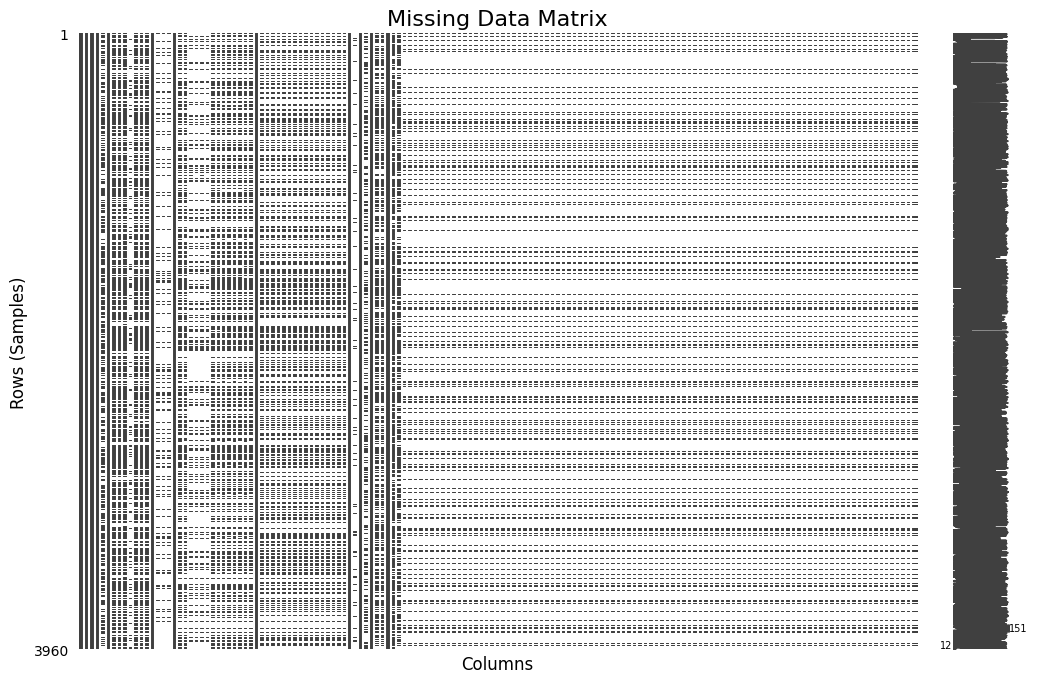

In [2]:
plt.figure(figsize=(12, 8))
msno.matrix(train, figsize=(12, 8), fontsize=8)
plt.title('Missing Data Matrix', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows (Samples)', fontsize=12)
plt.show()

In [3]:
missing_sii_records = train[train['sii'].isnull()]
available_sii_records = train[train['sii'].notnull()]

In [4]:
SEED = 42
n_splits = 5

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, X_train, y_train, X_test):
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    oof_non_rounded = np.zeros(len(y_train), dtype=float)
    oof_rounded = np.zeros(len(y_train), dtype=int)
    test_preds = np.zeros((len(X_test), n_splits))
    
    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X_train, y_train), desc="Training Folds", total=n_splits)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = clone(model_class)
        model.fit(X_tr, y_tr)

        y_val_pred = model.predict(X_val)
        oof_non_rounded[val_idx] = y_val_pred
        oof_rounded[val_idx] = y_val_pred.round(0).astype(int)

        test_preds[:, fold] = model.predict(X_test)

    KappaOPtimizer = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5], args=(y_train, oof_non_rounded), method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tpTuned, model

# Step 1: Split the available and missing sii records
available_sii_records = train[train['sii'].notnull()].copy()
missing_sii_records = train[train['sii'].isnull()].copy()

X_train_avail = available_sii_records.drop('sii', axis=1)
y_train_avail = available_sii_records['sii']
X_train_missing = missing_sii_records.drop('sii', axis=1)

# Step 2: Train model on available sii data and predict missing sii values
Params7 = {
    'learning_rate': 0.03884249148676395, 
    'max_depth': 12, 
    'num_leaves': 413, 
    'min_data_in_leaf': 14,
    'feature_fraction': 0.7987976913702801, 
    'bagging_fraction': 0.7602261703576205, 
    'bagging_freq': 2, 
    'lambda_l1': 4.735462555910575, 
    'lambda_l2': 4.735028557007343e-06,
    'n_estimators': 200,
    'random_state': SEED,
    'verbose': -1 
}
Light = lgb.LGBMRegressor(**Params7)

predicted_sii_for_missing, _ = TrainML(Light, X_train_avail, y_train_avail, X_train_missing)

# Step 3: Combine the predicted `sii` records with the available records
missing_sii_records['sii'] = predicted_sii_for_missing
combined_train = pd.concat([available_sii_records, missing_sii_records], axis=0)

X_train_combined = combined_train.drop('sii', axis=1)
y_train_combined = combined_train['sii']

# Step 4: Retrain the model on the combined dataset
final_preds, final_model = TrainML(Light, X_train_combined, y_train_combined, test)

# Step 5: Prepare the submission
submission = pd.DataFrame({
    'id': sample['id'],
    'sii': final_preds
})

Training Folds: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]


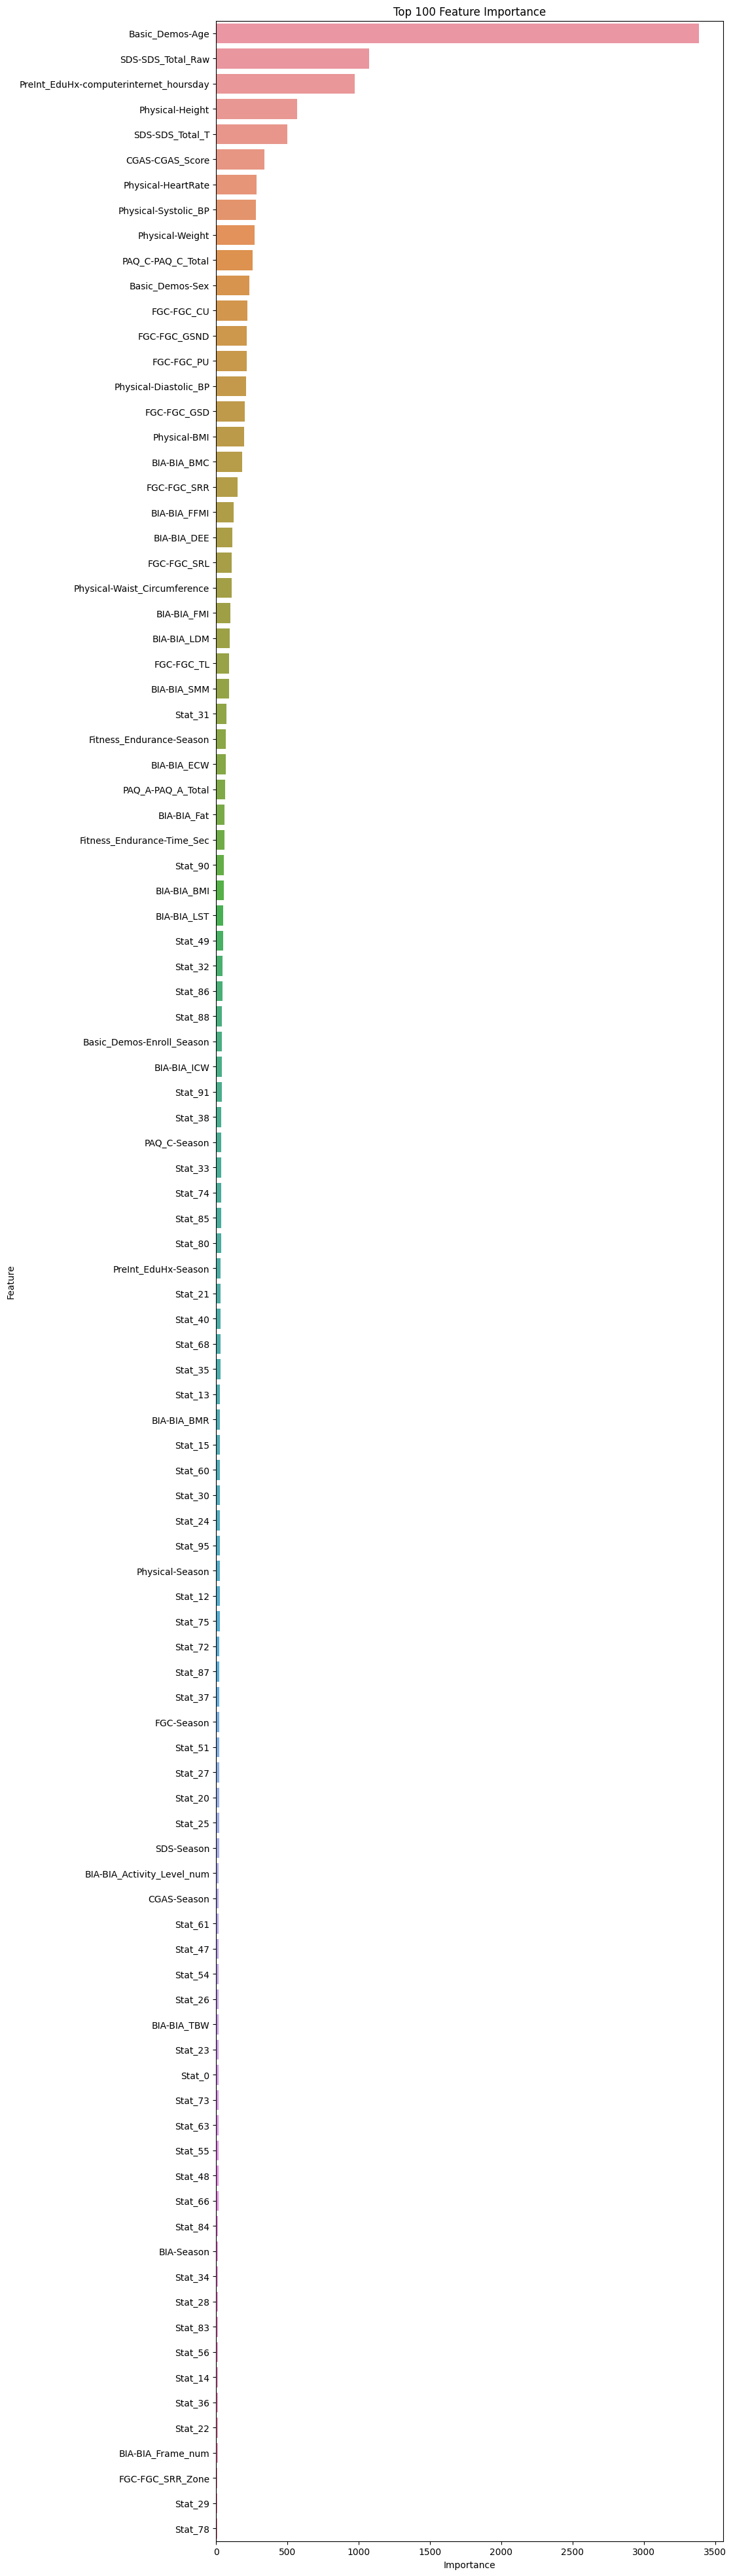

In [5]:
# Assuming `model` is already trained with LightGBM (Light is a LightGBM model)
def plot_feature_importance(model, top_n=100):
    feature_importance_df = pd.DataFrame({
        'Feature': model.booster_.feature_name(),
        'Importance': model.booster_.feature_importance(importance_type='gain')
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, top_n / 2))  # Adjusting height to accommodate top N features
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n)) 
    plt.title(f"Top {top_n} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# Assuming the model (final_model) has been trained
plot_feature_importance(final_model, top_n=100)

In [6]:
submission.to_csv('submission.csv', index=False)
print(submission['sii'].value_counts())

sii
0    11
1     9
Name: count, dtype: int64
